Found 30 runs. Downloading data...
Data download complete.
  architecture      lr      wd   val_MSE
0          gcn  0.0005  0.0000  0.143311
1          gcn  0.0005  0.0001  0.143377
2          gcn  0.0005  0.0005  0.147161
3          gcn  0.0010  0.0000  0.108996
4          gcn  0.0010  0.0001  0.108473


/Users/victorwintherlarsen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/victorwintherlarsen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/victorwintherlarsen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


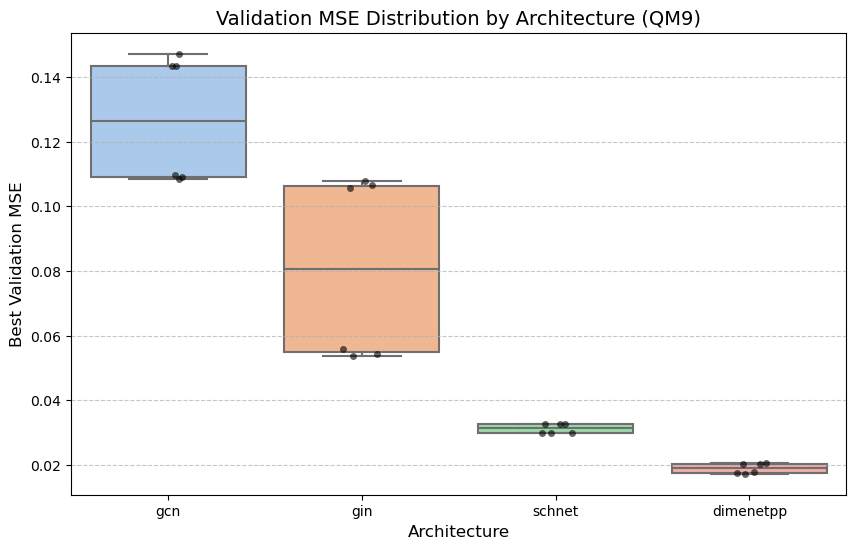

In [ ]:
import wandb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

api = wandb.Api()

ENTITY = "victorwinther-technical-university-of-denmark-"
PROJECT = "semi-supervised-learning-for-drug-discovery"
TARGET_GROUP = "arch_sweep_qm9"

runs = api.runs(f"{ENTITY}/{PROJECT}", filters={"group": TARGET_GROUP})

summary_data = []
history_data = []

print(f"Found {len(runs)} runs. Downloading data...")

for run in runs:
    cfg_model = run.config.get("model")
    if isinstance(cfg_model, dict):
        arch = cfg_model.get("name", "unknown")
    else:
        arch = cfg_model if cfg_model else "unknown"

    trainer_cfg = run.config.get("trainer", {})
    optim_cfg = trainer_cfg.get("init", {}).get("optimizer", {})
    
    lr = optim_cfg.get("lr", "unknown")
    wd = optim_cfg.get("weight_decay", "unknown")
    
    val_mse = run.summary.get("val_MSE") 
    
    summary_data.append({
        "architecture": arch,
        "lr": lr,
        "wd": wd,
        "val_MSE": val_mse  
    })

    try:
        hist = run.history(samples=500, keys=["epoch", "val_MSE"])
        hist["architecture"] = arch
        hist["lr"] = lr
        hist["wd"] = wd
        hist["run_name"] = run.name
        history_data.append(hist)
    except Exception as e:
        print(f"Could not fetch history for run {run.name}: {e}")

df_summary = pd.DataFrame(summary_data)
df_history = pd.concat(history_data) if history_data else pd.DataFrame()

print("Data download complete.")
print(df_summary.head()) 

df_summary["val_MSE"] = pd.to_numeric(df_summary["val_MSE"], errors='coerce')

df_summary = df_summary[df_summary["architecture"] != "visnet"]

if not df_summary.empty:
    plt.figure(figsize=(10, 6))

    sns.boxplot(
        data=df_summary,
        x="architecture",
        y="val_MSE", 
        palette="pastel",
        showfliers=False
    )

    sns.stripplot(
        data=df_summary,
        x="architecture",
        y="val_MSE",
        color="black",
        alpha=0.6,
        jitter=True
    )

    plt.title("Validation MSE Distribution by Architecture (QM9)", fontsize=14)
    plt.ylabel("Best Validation MSE", fontsize=12)
    plt.xlabel("Architecture", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.savefig("stage1_boxplot.pdf", bbox_inches='tight')
    plt.show()
else:
    print("DataFrame is empty.")

In [ ]:
best_indices = df_summary.groupby("architecture")["val_MSE"].idxmin()

best_runs = df_summary.loc[best_indices]

best_runs_sorted = best_runs.sort_values("val_MSE")

from IPython.display import display
display(best_runs_sorted[["architecture", "val_MSE", "lr", "wd"]])

,architecture,val_MSE,lr,wd
23,dimenetpp,0.017294,0.001,0.0005
17,schnet,0.029952,0.001,0.0005
10,gin,0.053700,0.001,0.0001
4,gcn,0.108473,0.001,0.0001


Found 30 runs. Re-downloading history...
Available potential columns: ['val_MSE']
Auto-detected metric column: val_MSE


/Users/victorwintherlarsen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/victorwintherlarsen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/victorwintherlarsen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/victorwintherlarsen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is de

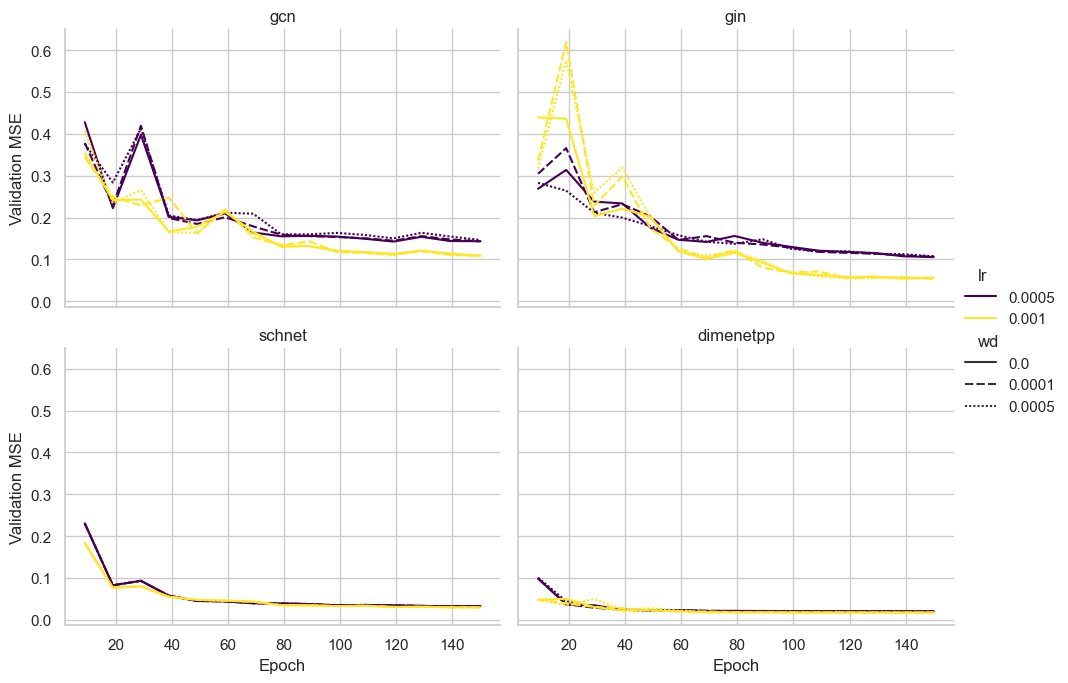

In [ ]:
import wandb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

api = wandb.Api()
ENTITY = "victorwinther-technical-university-of-denmark-"
PROJECT = "semi-supervised-learning-for-drug-discovery"
TARGET_GROUP = "arch_sweep_qm9"

runs = api.runs(f"{ENTITY}/{PROJECT}", filters={"group": TARGET_GROUP})
print(f"Found {len(runs)} runs. Re-downloading history...")

history_list = []

for run in runs:

    hist = run.history(samples=500) 

    if not hist.empty:
        hist["run_name"] = run.name
        
        cfg_model = run.config.get("model")
        if isinstance(cfg_model, dict):
            arch = cfg_model.get("name", "unknown")
        else:
            arch = cfg_model if cfg_model else "unknown"
        
        hist["architecture"] = arch
        hist["lr"] = run.config.get("trainer", {}).get("init", {}).get("optimizer", {}).get("lr", "unknown")
        hist["wd"] = run.config.get("trainer", {}).get("init", {}).get("optimizer", {}).get("weight_decay", "unknown")
        
        history_list.append(hist)

df_history = pd.concat(history_list)

potential_cols = [c for c in df_history.columns if "mse" in c.lower() or "val" in c.lower()]
print(f"Available potential columns: {potential_cols}")

actual_y_col = "val_mse" # 

if actual_y_col not in df_history.columns:
    candidates = [c for c in df_history.columns if "val" in c.lower() and "mse" in c.lower()]
    if candidates:
        actual_y_col = candidates[0]
        print(f"Auto-detected metric column: {actual_y_col}")

df_plot = df_history[df_history["architecture"] != "visnet"].copy()

if "epoch" not in df_plot.columns:
    df_plot.reset_index(inplace=True)
    if "_step" in df_plot.columns:
        df_plot.rename(columns={"_step": "epoch"}, inplace=True)
    elif "index" in df_plot.columns:
        df_plot.rename(columns={"index": "epoch"}, inplace=True)

df_plot[actual_y_col] = pd.to_numeric(df_plot[actual_y_col], errors='coerce')

sns.set_theme(style="whitegrid")
g = sns.relplot(
    data=df_plot,
    x="epoch", 
    y=actual_y_col,  
    col="architecture", 
    hue="lr", 
    style="wd",
    kind="line",
    col_wrap=2, 
    height=3.5, 
    aspect=1.4,
    palette="viridis",
    dashes=True
)

g.set_titles("{col_name}")
g.set_axis_labels("Epoch", "Validation MSE")

plt.savefig("stage1_learning_curves.pdf", bbox_inches='tight')
plt.show()

In [ ]:
import wandb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

api = wandb.Api()

ENTITY = "victorwinther-technical-university-of-denmark-"
PROJECT = "semi-supervised-learning-for-drug-discovery"

TARGET_TRAINERS = [
    "semi-supervised-ensemble", 
    "mean-teacher", 
    "consistency-aug", 
    "n-cps"
]

runs = api.runs(f"{ENTITY}/{PROJECT}", order="-created_at")

stage2_summary = []
stage2_history = []

print("Searching for Stage 2 runs...")

for run in runs:
    cfg_model = run.config.get("model", {})
    if isinstance(cfg_model, dict):
        model_name = cfg_model.get("name", "unknown")
    else:
        model_name = cfg_model
        
    if model_name != "dimenetpp":
        continue 

    trainer_cfg = run.config.get("trainer", "unknown")
    trainer_name = "unknown"
    
    if isinstance(trainer_cfg, str):
        trainer_name = trainer_cfg
    elif isinstance(trainer_cfg, dict):
        trainer_name = trainer_cfg.get("method", "unknown")
        
    if trainer_name not in TARGET_TRAINERS:
        if run.job_type in TARGET_TRAINERS:
            trainer_name = run.job_type
        else:
            continue 

    opt = run.config.get("trainer", {}).get("init", {}).get("optimizer", {})
    lr = opt.get("lr")
    wd = opt.get("weight_decay")

    if lr != 0.001 or wd != 0.0005:
        continue 

    print(f"Found Stage 2 run: {trainer_name} (Run ID: {run.id})")

    val_mse = run.summary.get("val_MSE") 
    
    stage2_summary.append({
        "trainer": trainer_name,
        "val_MSE": val_mse
    })

    hist = run.history(samples=500)
    if not hist.empty:
        hist["trainer"] = trainer_name
        stage2_history.append(hist)

print(f"Total Stage 2 runs found: {len(stage2_summary)}")

Searching for Stage 2 runs...
Found Stage 2 run: semi-supervised-ensemble (Run ID: 3vyiomnn)
Found Stage 2 run: semi-supervised-ensemble (Run ID: s8zajlgp)
Found Stage 2 run: semi-supervised-ensemble (Run ID: 5gudu8hz)
Total Stage 2 runs found: 3


Found 12 runs. Downloading data...


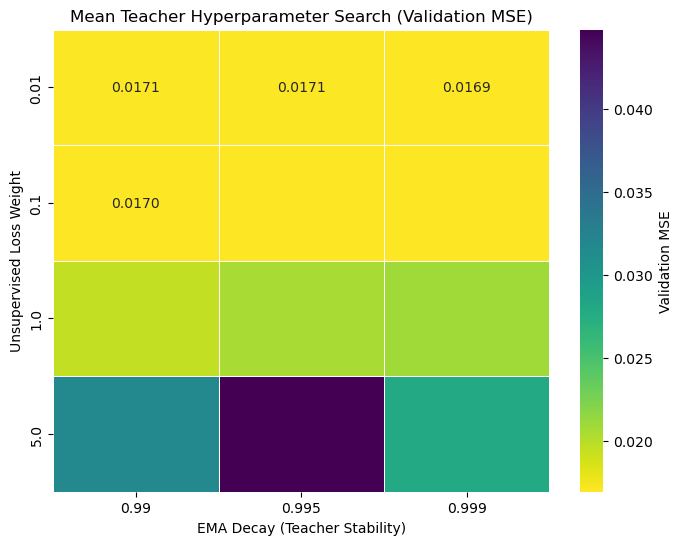

WINNING CONFIGURATION (Selected by Val):
Weight: 0.01
Decay:  0.999
----------------------------------------
Validation MSE: 0.01692
Test MSE:       0.02060  <-- USE THIS IN THE TEXT


In [ ]:
import wandb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

api = wandb.Api()

ENTITY = "victorwinther-technical-university-of-denmark-"
PROJECT = "semi-supervised-learning-for-drug-discovery"
TARGET_GROUP = "mean_teacher_hp_tuning" 

runs = api.runs(f"{ENTITY}/{PROJECT}", filters={"group": TARGET_GROUP})

data_list = []
print(f"Found {len(runs)} runs. Downloading data...")

for run in runs:
    trainer_init = run.config.get("trainer", {}).get("init", {})
    unsup_weight = trainer_init.get("unsup_weight", "unknown")
    ema_decay = trainer_init.get("ema_decay", "unknown")
    
    val_mse = run.summary.get("val_MSE")
    test_mse = run.summary.get("test_MSE") 
    
    if test_mse is None:
        test_mse = run.summary.get("test_mse")
    
    if val_mse is not None:
        data_list.append({
            "unsup_weight": unsup_weight,
            "ema_decay": ema_decay,
            "val_MSE": val_mse,
            "test_MSE": test_mse 
        })

df = pd.DataFrame(data_list)

cols = ["val_MSE", "test_MSE", "unsup_weight", "ema_decay"]
for c in cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

heatmap_data = df.pivot(index="unsup_weight", columns="ema_decay", values="val_MSE")
heatmap_data.sort_index(ascending=True, inplace=True)

plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data, 
    annot=True, 
    fmt=".4f", 
    cmap="viridis_r", 
    linewidths=.5,
    cbar_kws={'label': 'Validation MSE'}
)

plt.title("Mean Teacher Hyperparameter Search (Validation MSE)")
plt.xlabel("EMA Decay (Teacher Stability)")
plt.ylabel("Unsupervised Loss Weight")
plt.savefig("stage3_heatmap.pdf", bbox_inches='tight')
plt.show()

best_run_idx = df["val_MSE"].idxmin()
best_run = df.loc[best_run_idx]

print("="*40)
print(f"WINNING CONFIGURATION (Selected by Val):")
print(f"Weight: {best_run['unsup_weight']}")
print(f"Decay:  {best_run['ema_decay']}")
print(f"----------------------------------------")
print(f"Validation MSE: {best_run['val_MSE']:.5f}")
print(f"Test MSE:       {best_run['test_MSE']:.5f}  <-- USE THIS IN THE TEXT")
print("="*40)

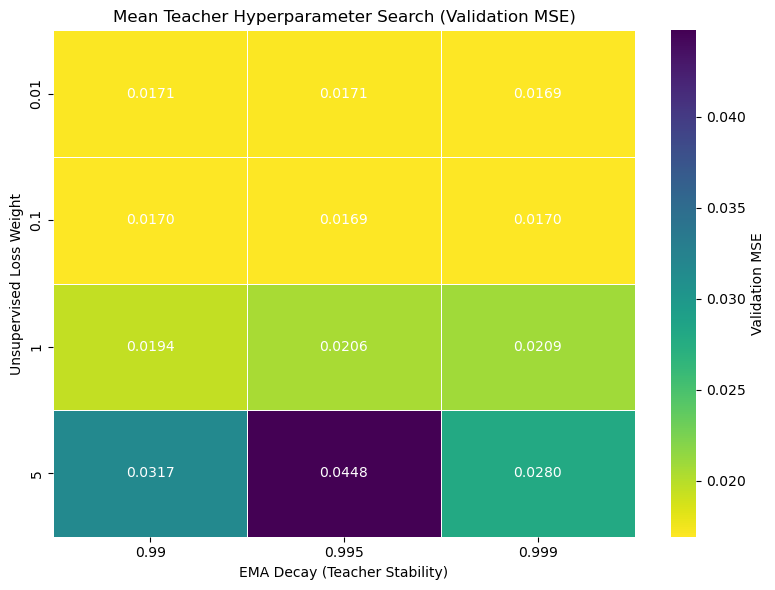

In [ ]:
plt.figure(figsize=(8, 6))

ax = sns.heatmap(
    heatmap_data,
    annot=False,          
    cmap="viridis_r",
    linewidths=.5,
    cbar_kws={'label': 'Validation MSE'}
)

for i in range(heatmap_data.shape[0]):     
    for j in range(heatmap_data.shape[1]):  
        val = heatmap_data.iloc[i, j]
        if pd.notna(val):
            ax.text(
                j + 0.5,
                i + 0.5,
                f"{val:.4f}",
                ha="center",
                va="center",
                color="white",  
                fontsize=10
            )

plt.title("Mean Teacher Hyperparameter Search (Validation MSE)")
plt.xlabel("EMA Decay (Teacher Stability)")
plt.ylabel("Unsupervised Loss Weight")
plt.tight_layout()
plt.savefig("stage3_heatmap.pdf", bbox_inches='tight')
plt.show()
